In [2]:
import pandas as pd
bel_data = pd.read_csv('/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bel_sentiment_emotion/sentiment_dataset.csv')

In [5]:
bbc_data = pd.read_csv("/Users/miraslavats/Library/CloudStorage/GoogleDrive-miraslava@uni.minerva.edu/My Drive/Capstone/bbc/sentiment_emotion_dataset.csv")

In [12]:
from google.cloud import language_v1
import pandas as pd
import os
from google.oauth2 import service_account

# Set up credentials (update with your actual file path)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = ""

# OR load credentials manually
credentials = service_account.Credentials.from_service_account_file("/Users/miraslavats/Desktop/entity-sentiment-450700-b2f24ddff1bd.json")

# Initialize Google Cloud NLP client
client = language_v1.LanguageServiceClient(credentials=credentials)

def analyze_entity_sentiment(text):
    """
    Analyzes entity sentiment for a given text using Google Cloud NLP.
    Returns a list of entities with their sentiment scores and salience.
    """
    if not text.strip():  # Skip empty texts
        return []

    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT, language="en")
    response = client.analyze_entity_sentiment(request={"document": document, "encoding_type": language_v1.EncodingType.UTF8})
    
    entity_data = []
    for entity in response.entities:
        entity_data.append({
            "Entity": entity.name,
            "Type": language_v1.Entity.Type(entity.type_).name,
            "Sentiment Score": entity.sentiment.score,  # Ranges from -1 (negative) to +1 (positive)
            "Sentiment Magnitude": entity.sentiment.magnitude,  # Indicates strength of sentiment
            "Salience": entity.salience  # Measures importance of the entity in the text (0-1)
        })
    
    return entity_data

# Apply the function to BBC and Belarusian media datasets
bel_data["Entity_Sentiment"] = bel_data["Processed_Chunks"].apply(analyze_entity_sentiment)
#bel_data["Entity_Sentiment"] = bel_data["Processed_Chunks"].apply(analyze_entity_sentiment)

# Display results
#bbc_data[["Processed_Chunks", "Entity_Sentiment"]].head()

In [31]:
bel_data['Date'] = pd.to_datetime(bel_data['Date'])
bel_data = bel_data[~bel_data['Date'].dt.year.eq(2022)]

In [32]:
import itertools

# Flatten entity lists
bbc_entities = list(itertools.chain(*bbc_data["Entity_Sentiment"].dropna()))
belarus_entities = list(itertools.chain(*bel_data["Entity_Sentiment"].dropna()))

# Convert to DataFrame
bbc_df = pd.DataFrame(bbc_entities)
belarus_df = pd.DataFrame(belarus_entities)

# Merge for comparison
comparison = pd.merge(bbc_df, belarus_df, on="Entity", suffixes=("_BBC", "_Belarus"), how="outer").fillna(0)
comparison = comparison.sort_values(by=["Sentiment Score_BBC", "Sentiment Score_Belarus"], ascending=False)

In [19]:
comparison.head()

,Entity,Type_BBC,Sentiment Score_BBC,Sentiment Magnitude_BBC,Salience_BBC,Type_Belarus,Sentiment Score_Belarus,Sentiment Magnitude_Belarus,Salience_Belarus
51684,speech,WORK_OF_ART,0.9,0.9,0.002694,WORK_OF_ART,0.9,0.9,0.009206
642818,president,PERSON,0.9,0.9,0.008711,PERSON,0.9,0.9,0.005012
642979,president,PERSON,0.9,0.9,0.008711,PERSON,0.9,0.9,0.008393
643316,president,PERSON,0.9,0.9,0.008711,PERSON,0.9,0.9,0.001789
643324,president,PERSON,0.9,0.9,0.008711,PERSON,0.9,0.9,0.009413


In [42]:
import matplotlib.pyplot as plt

def extract_entity_sentiment(df, entity_name):
    """
    Extracts sentiment scores for a given entity over time from a DataFrame.
    """
    sentiments = []
    for idx, row in df.iterrows():
        for entity in row["Entity_Sentiment"]:
            if entity["Entity"] == entity_name:
                sentiments.append({"Date": row["Date"], "Sentiment": entity["Sentiment Score"]})
    
    return pd.DataFrame(sentiments)

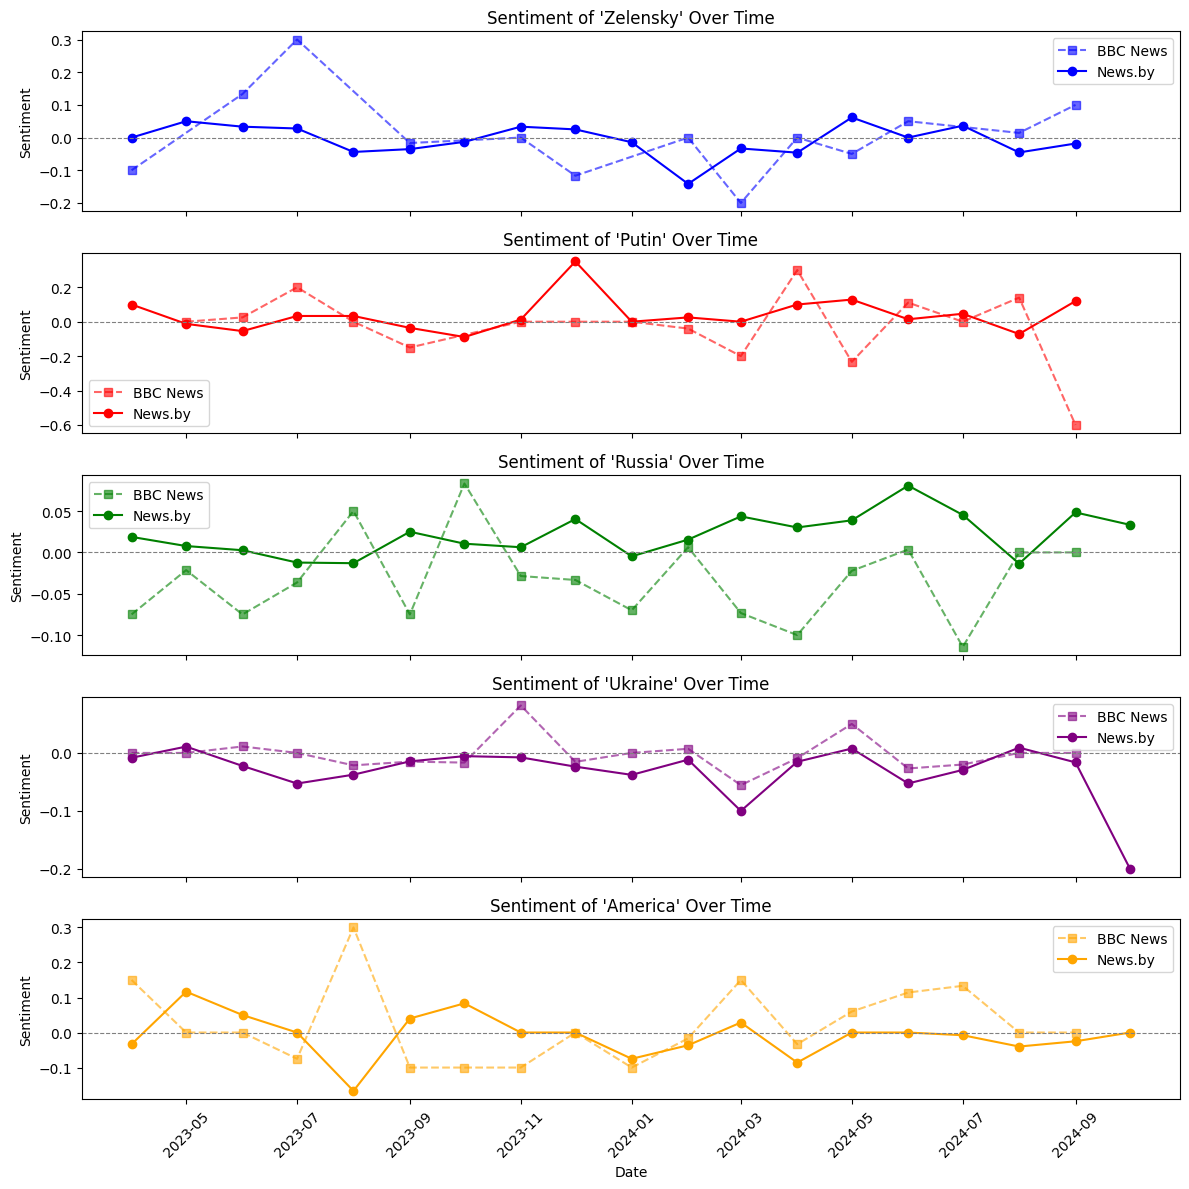

In [59]:
import matplotlib.pyplot as plt

# Defining the entities for plotting
entities = ["Zelensky", "Putin", "Russia", "Ukraine", "America"]
colors = ["blue", "red", "green", "purple", "orange"]

fig, axes = plt.subplots(len(entities), 1, figsize=(12, 12), sharex=True)

for ax, entity, color in zip(axes, entities, colors):
    # Sentient data
    bbc_sentiment = extract_entity_sentiment(bbc_data, entity)
    belarus_sentiment = extract_entity_sentiment(bel_data, entity)

    # Converting data to datetime
    bbc_sentiment["Date"] = pd.to_datetime(bbc_sentiment["Date"])
    belarus_sentiment["Date"] = pd.to_datetime(belarus_sentiment["Date"])
    bbc_sentiment = bbc_sentiment.sort_values("Date").groupby("Date")["Sentiment"].mean().reset_index()
    belarus_sentiment = belarus_sentiment.sort_values("Date").groupby("Date")["Sentiment"].mean().reset_index()

    ax.plot(bbc_sentiment["Date"], bbc_sentiment["Sentiment"], marker="s", linestyle="--", label="BBC News", color=color, alpha=0.6)
    ax.plot(belarus_sentiment["Date"], belarus_sentiment["Sentiment"], marker="o", linestyle="-", label="News.by", color=color)

    ax.axhline(y=0, color="gray", linestyle="--", linewidth=0.8)  # Neutral sentiment line
    ax.set_ylabel("Sentiment")
    ax.set_title(f"Sentiment of '{entity}' Over Time")
    ax.legend()

plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("entity-sentiment_general.png", dpi=300, bbox_inches='tight')
plt.show()

In [46]:
entities = ["Zelensky", "Putin", "Russia", "Ukraine", "America"]

def calculate_avg_sentiment_by_entity(data, entities):
    """Calculates average sentiment for each entity in the dataset."""
    summary = []
    for entity in entities:
        entity_data = extract_entity_sentiment(data, entity)  # Extract sentiment for the entity
        avg_sentiment = entity_data["Sentiment"].mean()  # Compute average sentiment
        summary.append({"Entity": entity, "Avg Sentiment": avg_sentiment})  # Store in list
    return pd.DataFrame(summary)  # Convert list to DataFrame

# Compute summaries for BBC and Belarusian media
bbc_entity_summary = round(calculate_avg_sentiment_by_entity(bbc_data, entities), 3)
bel_entity_summary = round(calculate_avg_sentiment_by_entity(bel_data, entities), 3)

# Display the results
print("BBC Entity Sentiment Summary:\n", bbc_entity_summary)
print("\nBelarusian Media Entity Sentiment Summary:\n", bel_entity_summary)

BBC Entity Sentiment Summary:
      Entity  Avg Sentiment
0  Zelensky          0.015
1     Putin         -0.000
2    Russia         -0.025
3   Ukraine         -0.005
4   America          0.054

Belarusian Media Entity Sentiment Summary:
      Entity  Avg Sentiment
0  Zelensky         -0.010
1     Putin          0.021
2    Russia          0.020
3   Ukraine         -0.019
4   America          0.001


### Within Russian War topic

In [47]:
russian_war_bel = bel_data[bel_data["Group"] == "Belarusian opposition"]
russian_war_bbc = bbc_data[bbc_data["Group"] == "Russian War on Ukraine"]

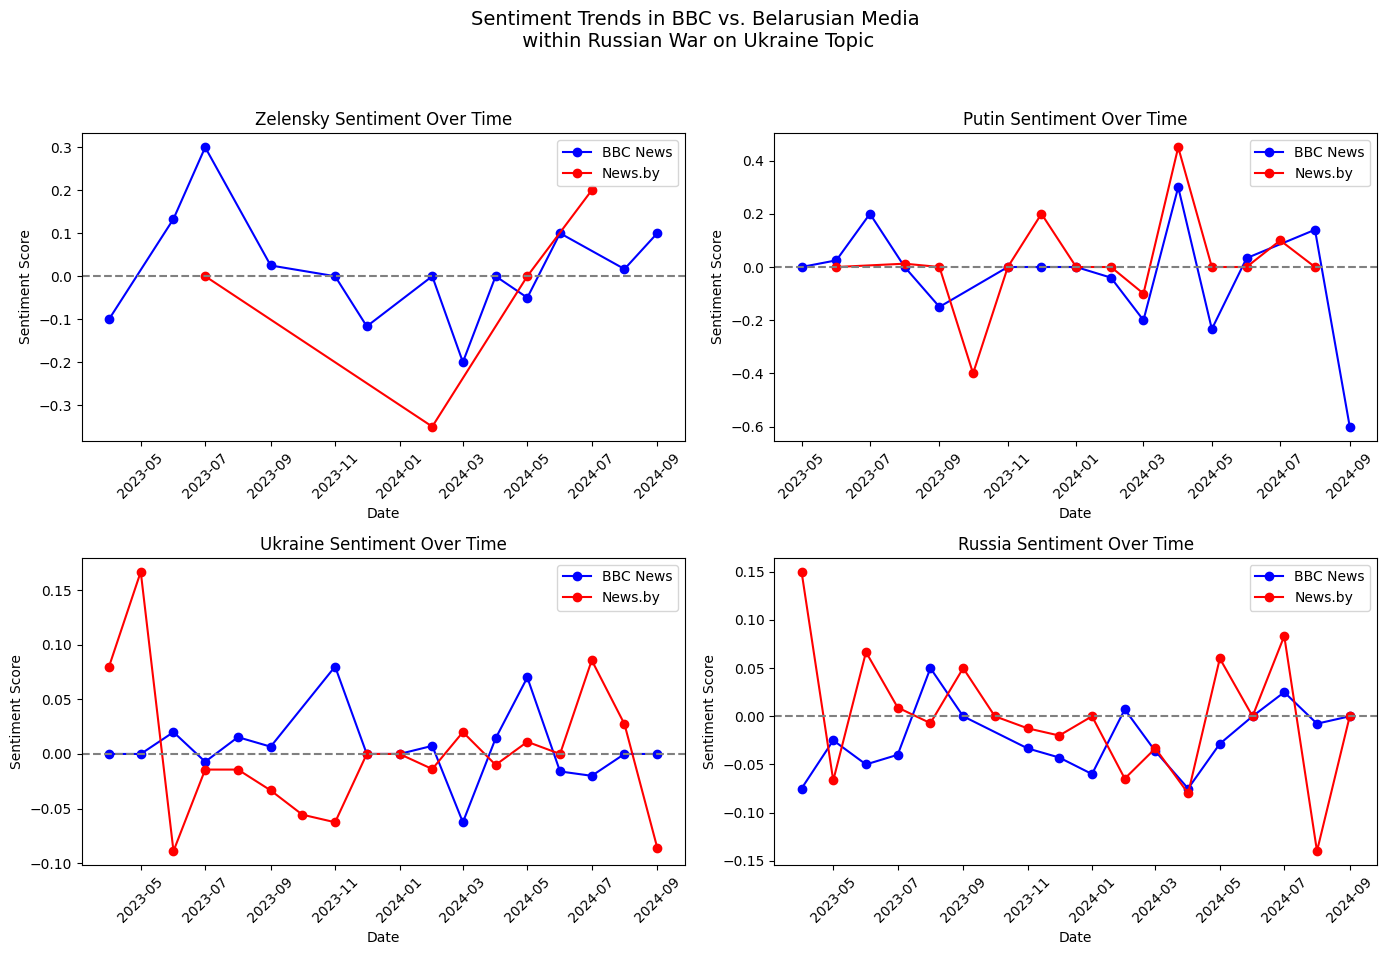

In [65]:
# Extract sentiment for each entity in both datasets
zelensky_bbc = extract_entity_sentiment(russian_war_bbc, "Zelensky")
zelensky_belarus = extract_entity_sentiment(russian_war_bel, "Nazis")

putin_bbc = extract_entity_sentiment(russian_war_bbc, "Putin")
putin_belarus = extract_entity_sentiment(russian_war_bel, "Putin")

ukraine_bbc = extract_entity_sentiment(russian_war_bbc, "Ukraine")
ukraine_belarus = extract_entity_sentiment(russian_war_bel, "Ukraine")

russia_bbc = extract_entity_sentiment(russian_war_bbc, "Russia")
russia_belarus = extract_entity_sentiment(russian_war_bel, "Russia")

# Convert dates, sort, and ensure proper grouping
def preprocess_sentiment(df):
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"])  # Drop rows with NaT values
    df = df.sort_values("Date")
    return df.groupby("Date", as_index=False)["Sentiment"].mean()

# Apply preprocessing
zelensky_bbc = preprocess_sentiment(zelensky_bbc)
zelensky_belarus = preprocess_sentiment(zelensky_belarus)
putin_bbc = preprocess_sentiment(putin_bbc)
putin_belarus = preprocess_sentiment(putin_belarus)
ukraine_bbc = preprocess_sentiment(ukraine_bbc)
ukraine_belarus = preprocess_sentiment(ukraine_belarus)
russia_bbc = preprocess_sentiment(russia_bbc)
russia_belarus = preprocess_sentiment(russia_belarus)

# Set up a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Sentiment Trends in BBC vs. Belarusian Media\n within Russian War on Ukraine Topic", fontsize=14)

# Function to plot sentiment
def plot_sentiment(ax, bbc_df, belarus_df, title):
    ax.plot(bbc_df["Date"], bbc_df["Sentiment"], label="BBC News", color="blue", linestyle="-", marker="o")
    ax.plot(belarus_df["Date"], belarus_df["Sentiment"], label="News.by", color="red", linestyle="-", marker="o")
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Sentiment Score")
    ax.legend()
    ax.tick_params(axis="x", rotation=45)

# Plot each entity's sentiment
plot_sentiment(axes[0, 0], zelensky_bbc, zelensky_belarus, "Zelensky Sentiment Over Time")
plot_sentiment(axes[0, 1], putin_bbc, putin_belarus, "Putin Sentiment Over Time")
plot_sentiment(axes[1, 0], ukraine_bbc, ukraine_belarus, "Ukraine Sentiment Over Time")
plot_sentiment(axes[1, 1], russia_bbc, russia_belarus, "Russia Sentiment Over Time")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("topics_entity.png", dpi=300, bbox_inches='tight')
plt.show()

### US politics

In [50]:
us_politics_bel = bel_data[bel_data["Group"] == "US-Related Politics"]
us_politics_bbc = bbc_data[bbc_data["Group"] == "US-Related Politics"]

#### !!! THE DIfference between how i filtered for the us and america!!

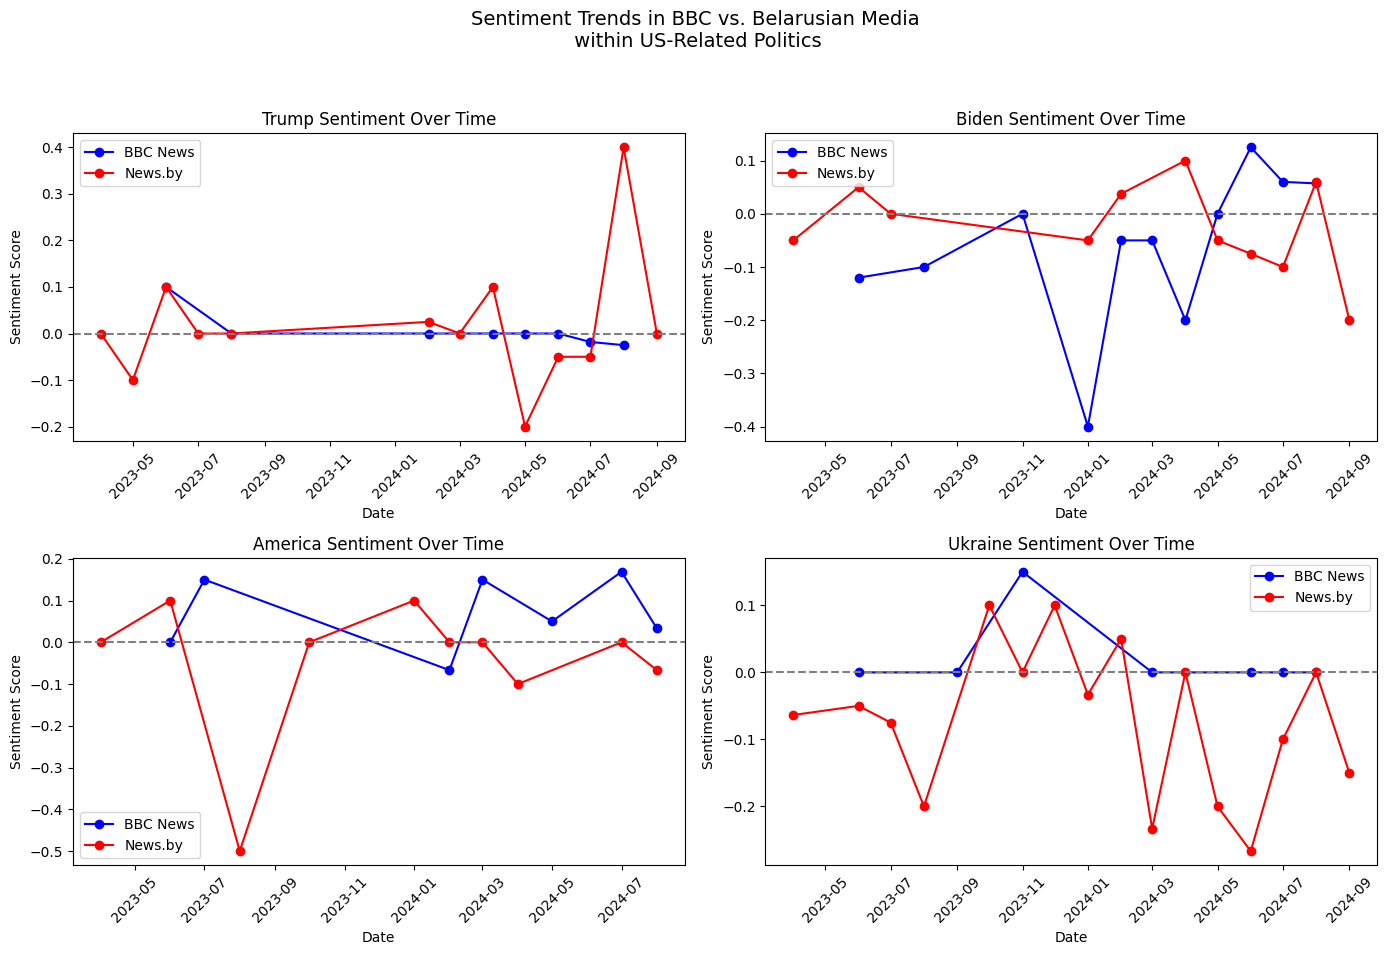

In [61]:
# Extract sentiment for each entity in both datasets
zelensky_bbc = extract_entity_sentiment(us_politics_bbc, "Trump")
zelensky_belarus = extract_entity_sentiment(us_politics_bel, "Trump")

putin_bbc = extract_entity_sentiment(us_politics_bbc, "Biden")
putin_belarus = extract_entity_sentiment(us_politics_bel, "Biden")

ukraine_bbc = extract_entity_sentiment(us_politics_bbc, "America")
ukraine_belarus = extract_entity_sentiment(us_politics_bel, "America")

russia_bbc = extract_entity_sentiment(us_politics_bbc, "Ukraine")
russia_belarus = extract_entity_sentiment(us_politics_bel, "Ukraine")

# Convert dates, sort, and ensure proper grouping
def preprocess_sentiment(df):
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"])  # Drop rows with NaT values
    df = df.sort_values("Date")
    return df.groupby("Date", as_index=False)["Sentiment"].mean()

# Apply preprocessing
zelensky_bbc = preprocess_sentiment(zelensky_bbc)
zelensky_belarus = preprocess_sentiment(zelensky_belarus)
putin_bbc = preprocess_sentiment(putin_bbc)
putin_belarus = preprocess_sentiment(putin_belarus)
ukraine_bbc = preprocess_sentiment(ukraine_bbc)
ukraine_belarus = preprocess_sentiment(ukraine_belarus)
russia_bbc = preprocess_sentiment(russia_bbc)
russia_belarus = preprocess_sentiment(russia_belarus)

# Set up a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Sentiment Trends in BBC vs. Belarusian Media\n within US-Related Politics", fontsize=14)

# Function to plot sentiment
def plot_sentiment(ax, bbc_df, belarus_df, title):
    ax.plot(bbc_df["Date"], bbc_df["Sentiment"], label="BBC News", color="blue", linestyle="-", marker="o")
    ax.plot(belarus_df["Date"], belarus_df["Sentiment"], label="News.by", color="red", linestyle="-", marker="o")
    ax.axhline(y=0, color="gray", linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Sentiment Score")
    ax.legend()
    ax.tick_params(axis="x", rotation=45)

# Plot each entity's sentiment
plot_sentiment(axes[0, 0], zelensky_bbc, zelensky_belarus, "Trump Sentiment Over Time")
plot_sentiment(axes[0, 1], putin_bbc, putin_belarus, "Biden Sentiment Over Time")
plot_sentiment(axes[1, 0], ukraine_bbc, ukraine_belarus, "America Sentiment Over Time")
plot_sentiment(axes[1, 1], russia_bbc, russia_belarus, "Ukraine Sentiment Over Time")

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("us_related_topic_entity.png", dpi=300, bbox_inches='tight')
plt.show()